In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('df_alldata.csv')

data.head()



,client_id,variation,tenure_year,tenure_month,age,gender,accounts,balance,calls_semester,logons_semester,balance_thousands,visitor_id,visit_id,process_step,date_time
0,9988021,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,189.02,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,189.02,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,189.02,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,189.02,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,189.02,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


In [5]:
data['date_time'] = pd.to_datetime(data['date_time'], errors='coerce')


data = data.dropna(subset=['date_time'])

In [16]:
# First, sort the data by 'visit_id' and 'date_time' to ensure process steps are in ascending order within each visit
data_sorted = data.sort_values(by=['visit_id', 'date_time'])

# Display the first few rows to verify that sorting is correct
data_sorted.head()

,client_id,variation,tenure_year,tenure_month,age,gender,accounts,balance,calls_semester,logons_semester,balance_thousands,visitor_id,visit_id,process_step,date_time
111379,3561384,Test,4.0,56.0,59.5,U,2.0,63130.44,6.0,9.0,63.13,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:22:17
111378,3561384,Test,4.0,56.0,59.5,U,2.0,63130.44,6.0,9.0,63.13,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:23:09
246767,7338123,Test,7.0,88.0,23.5,M,2.0,26436.73,6.0,9.0,26.44,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56
246766,7338123,Test,7.0,88.0,23.5,M,2.0,26436.73,6.0,9.0,26.44,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12
246765,7338123,Test,7.0,88.0,23.5,M,2.0,26436.73,6.0,9.0,26.44,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21


In [23]:
# Define the steps that each visit_id must contain to be considered complete
required_steps = {"start", "step_1", "step_2", "step_3", "confirm"}

# Group by visit_id and collect all unique steps for each visit
visit_steps_presence = data_sorted.groupby('visit_id')['process_step'].apply(set).reset_index()

# Check if each visit_id contains all required steps
visit_steps_presence['has_all_steps'] = visit_steps_presence['process_step'].apply(lambda steps: required_steps.issubset(steps))

# Count the number of visit_ids that contain all the required steps
total_with_all_steps = visit_steps_presence['has_all_steps'].sum()
total_with_all_steps

25174

In [24]:
# Merge the 'variation' column to associate each visit_id with its group (Control or Test)
visit_steps_with_variation = pd.merge(visit_steps_presence, variation_info, on='visit_id', how='left')

# Calculate the total number of visit_ids with all required steps for each group
total_with_all_steps_by_group = visit_steps_with_variation.groupby('variation')['has_all_steps'].sum()
total_with_all_steps_by_group

variation
Control    10944
Test       14316
Name: has_all_steps, dtype: int64

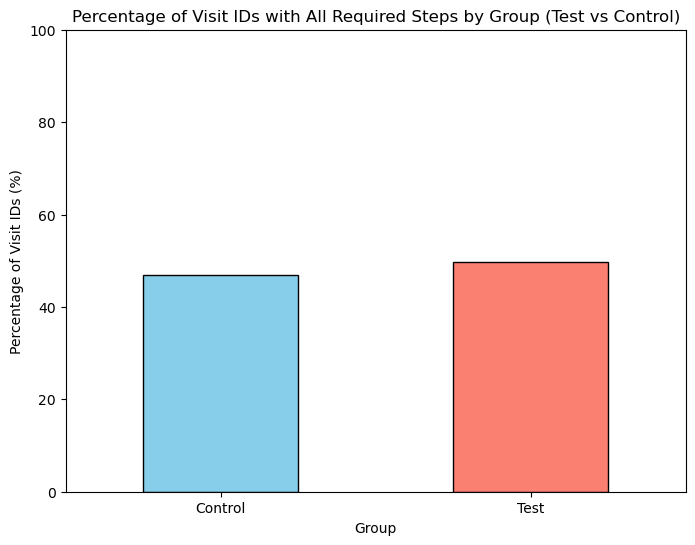

In [25]:
# Calculate the total number of visit_ids in each group (for percentage calculation)
total_counts_by_group = visit_steps_with_variation['variation'].value_counts()

# Calculate the percentage of visit_ids with all required steps for each group
percentage_with_all_steps_by_group = (total_with_all_steps_by_group / total_counts_by_group) * 100

# Plot the percentage of visit_ids with all required steps by group
plt.figure(figsize=(8, 6))
percentage_with_all_steps_by_group.plot(kind='bar', color=['skyblue', 'salmon'], edgecolor='black')
plt.title('Percentage of Visit IDs with All Required Steps by Group (Test vs Control)')
plt.ylabel('Percentage of Visit IDs (%)')
plt.xlabel('Group')
plt.xticks(rotation=0)
plt.ylim(0, 100)  # Set y-axis from 0 to 100 for percentage interpretation
plt.show()

In [27]:
# Calculate the completion rates for both groups
completion_rate_control = (total_with_all_steps_by_group['Control'] / total_counts_by_group['Control']) * 100
completion_rate_test = (total_with_all_steps_by_group['Test'] / total_counts_by_group['Test']) * 100

# Check if the Test group's completion rate is at least 5% higher than the Control group's
rate_difference = completion_rate_test - completion_rate_control
is_cost_effective = rate_difference >= 5

completion_rate_control, completion_rate_test, rate_difference, is_cost_effective

(46.93369928810361, 49.78093052368037, 2.847231235576757, False)

In [28]:
from statsmodels.stats.proportion import proportions_ztest

# Success counts and total counts for each group
success_counts = [total_with_all_steps_by_group['Test'], total_with_all_steps_by_group['Control']]
nobs = [total_counts_by_group['Test'], total_counts_by_group['Control']]

# Perform a one-sided (right-tailed) Z-test for proportions
stat, p_value = proportions_ztest(success_counts, nobs, alternative='larger')

# Determine if the p-value is less than the significance level (alpha = 0.05)
alpha = 0.05
is_statistically_significant = p_value < alpha

stat, p_value, is_statistically_significant

(6.464766833812742, 5.0727561648455804e-11, True)

/var/folders/5j/rbw66y292j36gxy345r1m_sw0000gn/T/ipykernel_55134/1405380395.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  completion_by_age_and_group = completed_data_with_age.groupby(['variation', 'age_group'])['has_all_steps'].sum()
/var/folders/5j/rbw66y292j36gxy345r1m_sw0000gn/T/ipykernel_55134/1405380395.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_by_age_and_group = data_sorted.groupby(['variation', 'age_group'])['visit_id'].nunique()


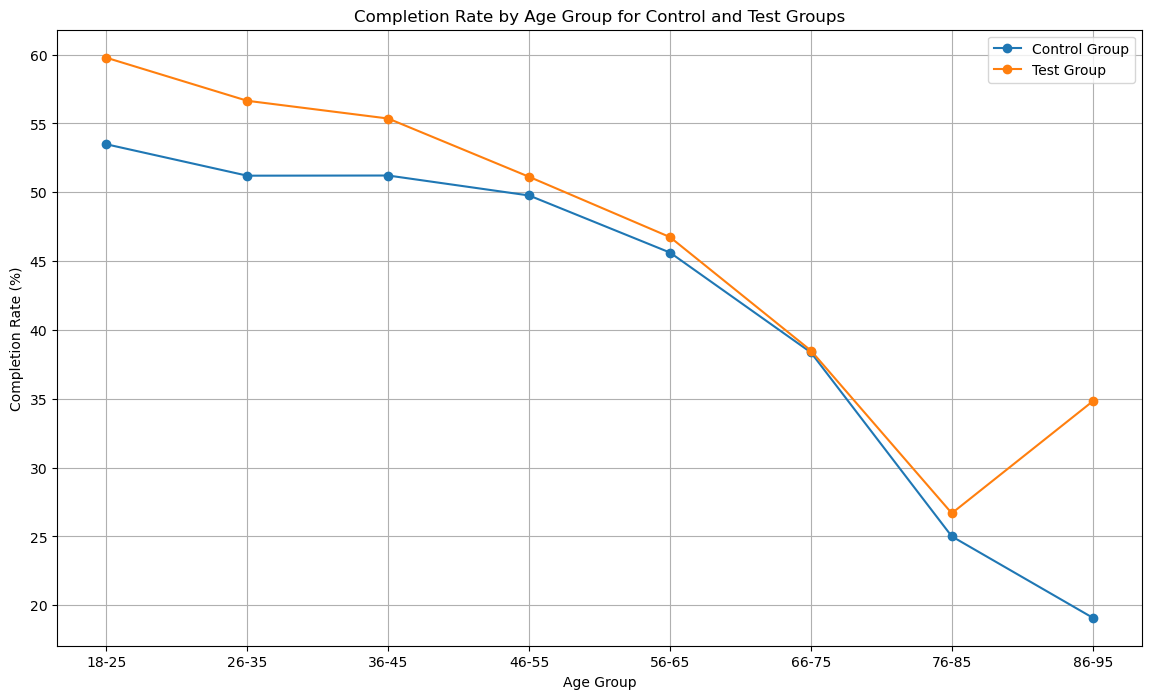

In [31]:
# Define age bins and labels
age_bins = [18, 25, 35, 45, 55, 65, 75, 85, 95]
age_labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85', '86-95']
data_sorted['age_group'] = pd.cut(data_sorted['age'], bins=age_bins, labels=age_labels, right=False)

# Filter for completed visits only
completed_visits = visit_steps_with_variation[visit_steps_with_variation['has_all_steps'] == True]

# Merge with age group data
completed_data_with_age = pd.merge(completed_visits[['visit_id', 'variation', 'has_all_steps']],
                                   data_sorted[['visit_id', 'age_group']].drop_duplicates(),
                                   on='visit_id', how='left')

# Calculate completion rates by age group and variation
completion_by_age_and_group = completed_data_with_age.groupby(['variation', 'age_group'])['has_all_steps'].sum()
total_by_age_and_group = data_sorted.groupby(['variation', 'age_group'])['visit_id'].nunique()
completion_rate_by_age_and_group = (completion_by_age_and_group / total_by_age_and_group) * 100
completion_rate_by_age_and_group = completion_rate_by_age_and_group.reset_index(name='completion_rate')

# Plotting completion rate by age group for Control and Test groups
plt.figure(figsize=(14, 8))
for variation in completion_rate_by_age_and_group['variation'].unique():
    age_group_data = completion_rate_by_age_and_group[completion_rate_by_age_and_group['variation'] == variation]
    plt.plot(age_group_data['age_group'], age_group_data['completion_rate'], marker='o', label=f'{variation} Group')

plt.title('Completion Rate by Age Group for Control and Test Groups')
plt.xlabel('Age Group')
plt.ylabel('Completion Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/var/folders/5j/rbw66y292j36gxy345r1m_sw0000gn/T/ipykernel_55134/840504275.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  completion_by_tenure_and_group = completed_data_with_tenure.groupby(['variation', 'tenure_group'])['has_all_steps'].sum()
/var/folders/5j/rbw66y292j36gxy345r1m_sw0000gn/T/ipykernel_55134/840504275.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_by_tenure_and_group = data_sorted.groupby(['variation', 'tenure_group'])['visit_id'].nunique()


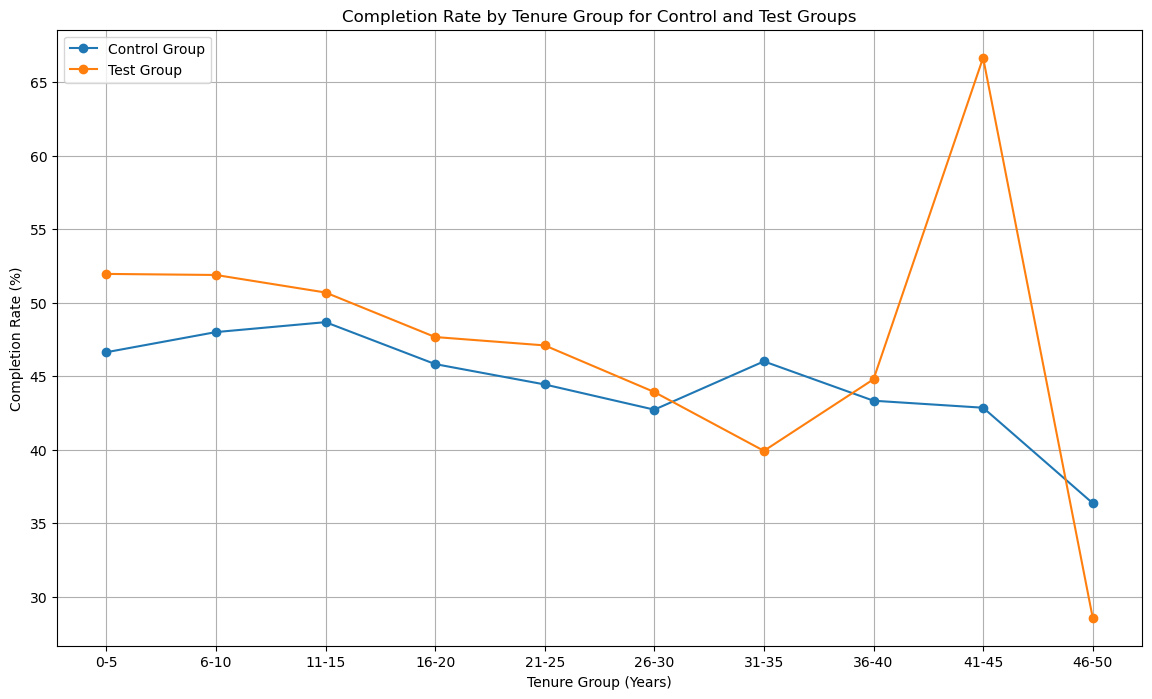

In [34]:
# Define bins and labels for tenure years
tenure_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
tenure_labels = ['0-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50']

# Add a tenure year group column based on the defined bins
data_sorted['tenure_group'] = pd.cut(data_sorted['tenure_year'], bins=tenure_bins, labels=tenure_labels, right=False)

# Filter for visit_ids that completed all steps
completed_visits = visit_steps_with_variation[visit_steps_with_variation['has_all_steps'] == True]

# Merge completion status with tenure year groups
completed_data_with_tenure = pd.merge(completed_visits[['visit_id', 'variation', 'has_all_steps']],
                                      data_sorted[['visit_id', 'tenure_group']].drop_duplicates(),
                                      on='visit_id', how='left')

# Calculate completion rates by tenure group and variation (Control and Test)
completion_by_tenure_and_group = completed_data_with_tenure.groupby(['variation', 'tenure_group'])['has_all_steps'].sum()
total_by_tenure_and_group = data_sorted.groupby(['variation', 'tenure_group'])['visit_id'].nunique()
completion_rate_by_tenure_and_group = (completion_by_tenure_and_group / total_by_tenure_and_group) * 100
completion_rate_by_tenure_and_group = completion_rate_by_tenure_and_group.reset_index(name='completion_rate')

# Plotting completion rate by tenure group for Control and Test groups
plt.figure(figsize=(14, 8))
for variation in completion_rate_by_tenure_and_group['variation'].unique():
    tenure_group_data = completion_rate_by_tenure_and_group[completion_rate_by_tenure_and_group['variation'] == variation]
    plt.plot(tenure_group_data['tenure_group'], tenure_group_data['completion_rate'], marker='o', label=f'{variation} Group')

plt.title('Completion Rate by Tenure Group for Control and Test Groups')
plt.xlabel('Tenure Group (Years)')
plt.ylabel('Completion Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
from statsmodels.stats.proportion import proportions_ztest

# Initialize a list to store results
significance_results = []

# Loop over each tenure group and perform a Z-test for proportions
for tenure_group in tenure_labels:
    # Extract completion counts and total counts for Control and Test within the current tenure group
    try:
        completed_control = completion_by_tenure_and_group.loc[('Control', tenure_group)]
        completed_test = completion_by_tenure_and_group.loc[('Test', tenure_group)]
        
        total_control = total_by_tenure_and_group.loc[('Control', tenure_group)]
        total_test = total_by_tenure_and_group.loc[('Test', tenure_group)]
        
        # Define success counts and total counts
        success_counts = [completed_test, completed_control]
        nobs = [total_test, total_control]

        # Perform the Z-test for a one-sided alternative (Test > Control)
        stat, p_value = proportions_ztest(success_counts, nobs, alternative='larger')
        is_significant = p_value < 0.05
        
        # Append results
        significance_results.append({
            'tenure_group': tenure_group,
            'completion_rate_control': (completed_control / total_control) * 100,
            'completion_rate_test': (completed_test / total_test) * 100,
            'p_value': p_value,
            'statistically_significant': is_significant
        })
        
    except KeyError:
        # In case of missing data for a tenure group (e.g., no control or test group in that range)
        significance_results.append({
            'tenure_group': tenure_group,
            'completion_rate_control': None,
            'completion_rate_test': None,
            'p_value': None,
            'statistically_significant': False
        })

# Convert results to DataFrame for easier viewing
significance_df = pd.DataFrame(significance_results)
significance_df

,tenure_group,completion_rate_control,completion_rate_test,p_value,statistically_significant
0,0-5,46.632711,51.959847,4.874757e-04,True
1,6-10,48.002336,51.887234,4.264674e-08,True
2,11-15,48.678248,50.693915,1.455287e-02,True
3,16-20,45.825349,47.665629,4.887971e-02,True
4,21-25,44.440169,47.096160,2.213681e-02,True
5,26-30,42.724458,43.923611,2.894147e-01,False
6,31-35,46.010638,39.923225,9.656151e-01,False
7,36-40,43.333333,44.791667,4.206652e-01,False
8,41-45,42.857143,66.666667,1.704519e-01,False
9,46-50,36.363636,28.571429,6.607799e-01,False


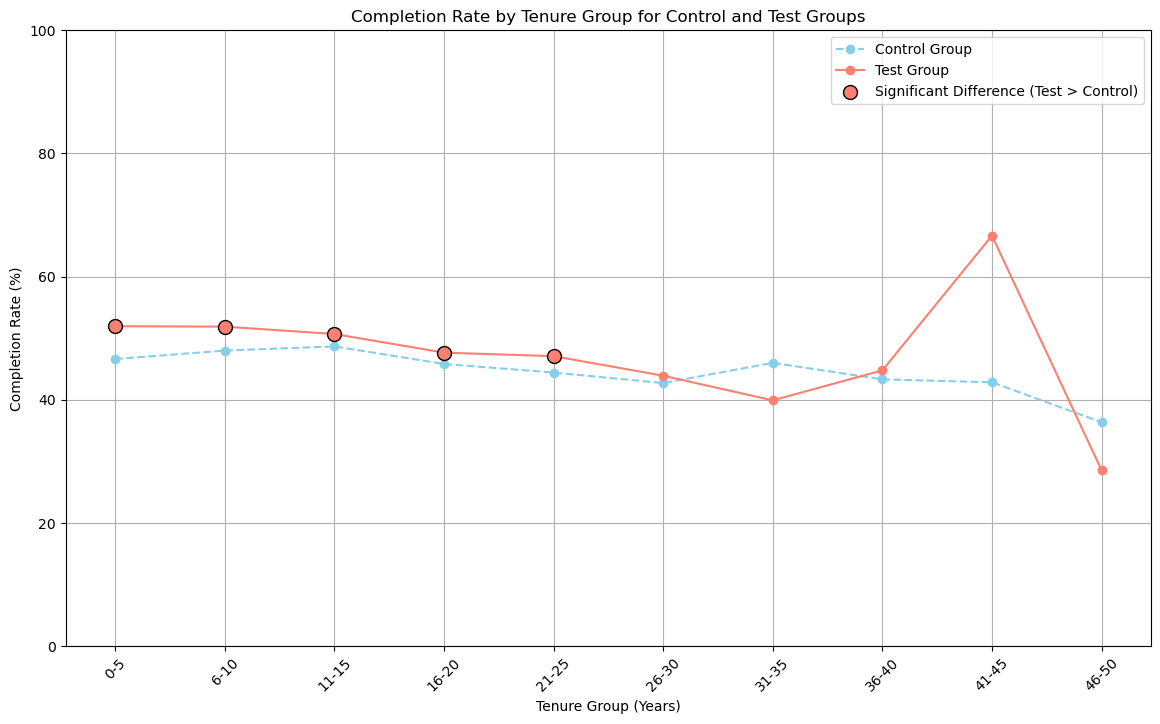

In [36]:
# Plotting completion rates for each tenure group for Control and Test groups with statistical significance

# Separate the tenure groups and their corresponding completion rates and significance
significant_groups = significance_df[significance_df['statistically_significant']]
non_significant_groups = significance_df[~significance_df['statistically_significant']]

plt.figure(figsize=(14, 8))

# Plot Control and Test completion rates with different markers for significance
plt.plot(significance_df['tenure_group'], significance_df['completion_rate_control'], 
         marker='o', label='Control Group', color='skyblue', linestyle='--', linewidth=1.5)

plt.plot(significance_df['tenure_group'], significance_df['completion_rate_test'], 
         marker='o', label='Test Group', color='salmon', linestyle='-', linewidth=1.5)

# Highlight significant points for the Test Group
plt.scatter(significant_groups['tenure_group'], significant_groups['completion_rate_test'], 
            color='salmon', edgecolor='black', s=100, zorder=5, label='Significant Difference (Test > Control)')

# Add labels and title
plt.title('Completion Rate by Tenure Group for Control and Test Groups')
plt.xlabel('Tenure Group (Years)')
plt.ylabel('Completion Rate (%)')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.legend()
plt.grid(True)

# Show plot
plt.show()

/var/folders/5j/rbw66y292j36gxy345r1m_sw0000gn/T/ipykernel_55134/4113655494.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  completion_by_age_and_group = completed_data_with_age.groupby(['variation', 'age_group'])['has_all_steps'].sum()
/var/folders/5j/rbw66y292j36gxy345r1m_sw0000gn/T/ipykernel_55134/4113655494.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_by_age_and_group = data_sorted.groupby(['variation', 'age_group'])['visit_id'].nunique()


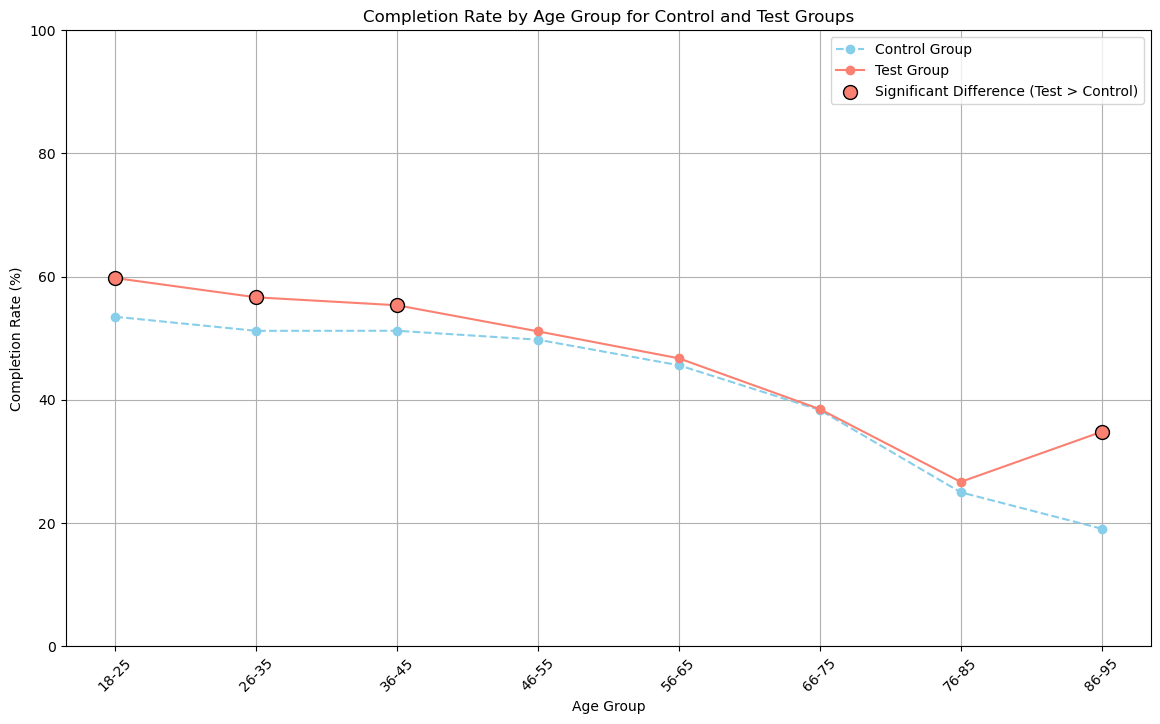

In [38]:
# Re-import necessary libraries for a fresh analysis environment
from statsmodels.stats.proportion import proportions_ztest

# Define age bins and labels for grouping
age_bins = [18, 25, 35, 45, 55, 65, 75, 85, 95]
age_labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85', '86-95']

# Add an age group column based on the defined bins
data_sorted['age_group'] = pd.cut(data_sorted['age'], bins=age_bins, labels=age_labels, right=False)

# Recreate the completion information with age groups
completed_visits = visit_steps_with_variation[visit_steps_with_variation['has_all_steps'] == True]

# Join the data with the age group info and variation
completed_data_with_age = pd.merge(completed_visits[['visit_id', 'variation', 'has_all_steps']],
                                   data_sorted[['visit_id', 'age_group']].drop_duplicates(),
                                   on='visit_id', how='left')

# Calculate completion rates by age group for each variation
completion_by_age_and_group = completed_data_with_age.groupby(['variation', 'age_group'])['has_all_steps'].sum()
total_by_age_and_group = data_sorted.groupby(['variation', 'age_group'])['visit_id'].nunique()

# Initialize a list to store results of the statistical significance tests by age group
age_significance_results = []

# Perform a Z-test for proportions for Control vs. Test across each age group
for age_group in age_labels:
    try:
        completed_control = completion_by_age_and_group.loc[('Control', age_group)]
        completed_test = completion_by_age_and_group.loc[('Test', age_group)]
        
        total_control = total_by_age_and_group.loc[('Control', age_group)]
        total_test = total_by_age_and_group.loc[('Test', age_group)]
        
        # Define success counts and total counts
        success_counts = [completed_test, completed_control]
        nobs = [total_test, total_control]

        # Perform the Z-test for a one-sided alternative (Test > Control)
        stat, p_value = proportions_ztest(success_counts, nobs, alternative='larger')
        is_significant = p_value < 0.05
        
        # Append results
        age_significance_results.append({
            'age_group': age_group,
            'completion_rate_control': (completed_control / total_control) * 100,
            'completion_rate_test': (completed_test / total_test) * 100,
            'p_value': p_value,
            'statistically_significant': is_significant
        })
        
    except KeyError:
        # Handle any missing data for specific age groups
        age_significance_results.append({
            'age_group': age_group,
            'completion_rate_control': None,
            'completion_rate_test': None,
            'p_value': None,
            'statistically_significant': False
        })

# Convert results to DataFrame for easier viewing and plotting
age_significance_df = pd.DataFrame(age_significance_results)

# Plotting completion rates by age group for Control and Test groups with statistical significance
plt.figure(figsize=(14, 8))

# Plot Control and Test completion rates with different markers for significance
plt.plot(age_significance_df['age_group'], age_significance_df['completion_rate_control'], 
         marker='o', label='Control Group', color='skyblue', linestyle='--', linewidth=1.5)

plt.plot(age_significance_df['age_group'], age_significance_df['completion_rate_test'], 
         marker='o', label='Test Group', color='salmon', linestyle='-', linewidth=1.5)

# Highlight significant points for the Test Group
significant_age_groups = age_significance_df[age_significance_df['statistically_significant']]
plt.scatter(significant_age_groups['age_group'], significant_age_groups['completion_rate_test'], 
            color='salmon', edgecolor='black', s=100, zorder=5, label='Significant Difference (Test > Control)')

# Add labels and title
plt.title('Completion Rate by Age Group for Control and Test Groups')
plt.xlabel('Age Group')
plt.ylabel('Completion Rate (%)')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.legend()
plt.grid(True)

# Show plot
plt.show()